preprocessing

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import os
warnings.filterwarnings('ignore')
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [2]:
def load_and_clean_data(file_path):
    df = pd.read_csv(file_path, delimiter=';', decimal=',')
    print(f"Shape data awal: {df.shape}")
    print(f"Kolom data: {df.columns.tolist()}")
    print(df.head())

    if 'created_at' not in df.columns:
        raise ValueError("Kolom 'created_at' tidak ditemukan dalam dataset.")

    df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')
    df = df.dropna(subset=['created_at'])
    df = df.sort_values('created_at').reset_index(drop=True)

    print(f"Rentang waktu: {df['created_at'].min()} sampai {df['created_at'].max()}")
    return df

In [3]:
def handle_missing_values(df):

    print("\n=== Analisis Missing Values ===")
    missing_info = df.isnull().sum()
    print(missing_info[missing_info > 0])
    
    # Untuk kolom numerik, gunakan interpolasi atau median
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    
    for col in numeric_cols:
        if df[col].isnull().sum() > 0:
            # Gunakan interpolasi linear untuk time series
            df[col] = df[col].interpolate(method='linear')
            # Isi sisa dengan median
            df[col] = df[col].fillna(df[col].median())
    
    return df

In [4]:
def detect_and_handle_outliers( df, method='iqr', threshold=3):
    print("\n=== Deteksi Outliers ===")
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    outlier_info = {}
    
    for col in numeric_cols:
        if method == 'iqr':
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            outliers = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
            
        elif method == 'zscore':
            z_scores = np.abs((df[col] - df[col].mean()) / df[col].std())
            outliers = (z_scores > threshold).sum()
        
        outlier_info[col] = outliers
        print(f"{col}: {outliers} outliers")
    
    return df, outlier_info

In [5]:
def feature_engineering(df):
    print("\n=== Feature Engineering ===")
    
    # Extract time features
    df['hour'] = df['created_at'].dt.hour
    df['day_of_week'] = df['created_at'].dt.dayofweek
    df['day_of_month'] = df['created_at'].dt.day
    
    # Rolling statistics (untuk menangkap trend)
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    numeric_cols = [col for col in numeric_cols if col not in ['hour', 'day_of_week', 'day_of_month']]
    
    window_sizes = [3, 5, 10]
    for window in window_sizes:
        for col in numeric_cols[:3]:  # Batasi untuk beberapa kolom utama
            df[f'{col}_rolling_mean_{window}'] = df[col].rolling(window=window, min_periods=1).mean()
            df[f'{col}_rolling_std_{window}'] = df[col].rolling(window=window, min_periods=1).std()
    
    # Lag features
    for col in numeric_cols[:3]:  # Batasi untuk beberapa kolom utama
        for lag in [1, 2, 3]:
            df[f'{col}_lag_{lag}'] = df[col].shift(lag)
    
    # Hapus baris dengan NaN akibat lag features
    df = df.dropna().reset_index(drop=True)
    
    print(f"Shape setelah feature engineering: {df.shape}")
    return df

In [6]:
def normalize_features(df, scaler, fit=True, feature_columns=None):
    print("\n=== Normalisasi ===")
    cols = df.select_dtypes(include=[np.number]).columns.tolist()
    
    if fit:
        scaled = scaler.fit_transform(df[cols])
        feature_columns = cols
    else:
        scaled = scaler.transform(df[feature_columns])
    
    df_scaled = df.copy()
    df_scaled[feature_columns] = scaled
    return df_scaled, feature_columns

In [7]:
def create_sequences(df, sequence_length=5, target_cols=None):
    print(f"\n=== Membuat Sequences (length={sequence_length}) ===")
    if target_cols is None:
        target_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    
    sequences = []
    timestamps = []
    for i in range(len(df) - sequence_length + 1):
        seq = df[target_cols].iloc[i:i+sequence_length].values
        sequences.append(seq)
        timestamps.append(df['created_at'].iloc[i+sequence_length-1])
    
    sequences = np.array(sequences)
    print(f"Shape sequences: {sequences.shape}")
    print(f"Jumlah sequences: {len(sequences)}")
    return sequences, timestamps

In [8]:
def split_data(sequences, timestamps, train_ratio=0.8):
    split = int(len(sequences) * train_ratio)
    X_train = sequences[:split]
    X_test = sequences[split:]
    train_timestamps = timestamps[:split]
    test_timestamps = timestamps[split:]
    print(f"\n=== Data Split ===")
    print(f"Training sequences: {X_train.shape}")
    print(f"Testing sequences: {X_test.shape}")
    return X_train, X_test, train_timestamps, test_timestamps

In [9]:
def plot_data_overview(df):
    numeric_cols = df.select_dtypes(include=[np.number]).columns[:6]
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()
    
    for i, col in enumerate(numeric_cols):
        if i < len(axes):
            axes[i].plot(df['created_at'], df[col])
            axes[i].set_title(f'{col} over time')
            axes[i].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(12, 8))
    corr = df[numeric_cols].corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
    plt.title('Feature Correlation Matrix')
    plt.show()

In [10]:
def main_preprocessing(file_path, sequence_length=10, scaler_type='minmax'):
    scaler = get_scaler(scaler_type)
    df = load_and_clean_data(file_path)
    df = handle_missing_values(df)
    df, outlier_info = detect_and_handle_outliers(df)
    # df = feature_engineering(df)
    print (df)
    df_scaled, feature_columns = normalize_features(df, scaler, fit=True)
    sequences, timestamps = create_sequences(df_scaled, sequence_length, target_cols=feature_columns)
    
    return {
        'data':df_scaled,
        'timestamps': timestamps,
        'sequences':sequences,
        'feature_columns': feature_columns,
        'original_df': df,
        'scaled_df': df_scaled
    }

In [11]:
def get_scaler(scaler_type='standard'):
    if scaler_type == 'standard':
        return StandardScaler()
    elif scaler_type == 'minmax':
        return MinMaxScaler()
    elif scaler_type == 'robust':
        return RobustScaler()

MODEL CREATIONS

In [12]:
def create_advanced_visualizations(history, train_mae, test_mae, train_repr, test_repr,
                                 thresholds, X_train, X_train_pred, X_test, X_test_pred,
                                 y_train=None, y_test=None):
    """Create comprehensive visualizations"""
    
    plt.style.use('default')
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Training History
    plt.subplot(3, 4, 1)
    plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
    plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.title('Training vs Validation Loss', fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 2. Reconstruction Error Distribution
    plt.subplot(3, 4, 2)
    plt.hist(train_mae, bins=50, alpha=0.7, label='Train MAE', density=True)
    plt.hist(test_mae, bins=50, alpha=0.7, label='Test MAE', density=True)
    
    # Plot thresholds
    colors = ['red', 'orange', 'purple']
    threshold_names = ['mae_percentile', 'mae_mean_std', 'mae_iqr']
    for i, name in enumerate(threshold_names):
        if name in thresholds:
            plt.axvline(thresholds[name], color=colors[i], linestyle='--', 
                       label=f'{name}: {thresholds[name]:.4f}')
    
    plt.xlabel('Reconstruction Error (MAE)')
    plt.ylabel('Density')
    plt.title('Error Distribution with Thresholds', fontweight='bold')
    plt.legend(fontsize=8)
    plt.grid(True, alpha=0.3)
    
    # 3. Box Plot of Errors
    plt.subplot(3, 4, 3)
    data_to_plot = [train_mae, test_mae]
    labels = ['Train', 'Test']
    if y_train is not None and y_test is not None:
        # Separate normal and anomaly if labels available
        normal_train = train_mae[y_train == 0] if len(y_train) > 0 else train_mae
        normal_test = test_mae[y_test == 0] if len(y_test) > 0 else test_mae
        anomaly_test = test_mae[y_test == 1] if len(y_test) > 0 and np.any(y_test == 1) else []
        
        data_to_plot = [normal_train, normal_test]
        labels = ['Train Normal', 'Test Normal']
        if len(anomaly_test) > 0:
            data_to_plot.append(anomaly_test)
            labels.append('Test Anomaly')
    
    plt.boxplot(data_to_plot, labels=labels)
    plt.ylabel('Reconstruction Error (MAE)')
    plt.title('Error Distribution Comparison', fontweight='bold')
    plt.grid(True, alpha=0.3)
    
    # 4. Representations Scatter Plot (2D projection)
    plt.subplot(3, 4, 4)
    try:
        # Handle different representation shapes
        if train_repr.ndim > 2:
            train_repr_2d = train_repr.reshape(train_repr.shape[0], -1)
            test_repr_2d = test_repr.reshape(test_repr.shape[0], -1)
        else:
            train_repr_2d = train_repr
            test_repr_2d = test_repr
            
        if train_repr_2d.shape[1] >= 2:
            plt.scatter(train_repr_2d[:, 0], train_repr_2d[:, 1], alpha=0.6, s=20, label='Train')
            plt.scatter(test_repr_2d[:, 0], test_repr_2d[:, 1], alpha=0.6, s=20, label='Test')
            plt.xlabel('Latent Dimension 1')
            plt.ylabel('Latent Dimension 2')
        elif train_repr_2d.shape[1] == 1:
            # 1D representation
            plt.scatter(range(len(train_repr_2d)), train_repr_2d[:, 0], alpha=0.6, s=20, label='Train')
            plt.scatter(range(len(test_repr_2d)), test_repr_2d[:, 0], alpha=0.6, s=20, label='Test')
            plt.xlabel('Sample Index')
            plt.ylabel('Latent Value')
        else:
            # If no proper dimensions, show a simple plot
            plt.text(0.5, 0.5, 'Representation\nvisualization\nnot available', 
                    ha='center', va='center', transform=plt.gca().transAxes)
        
        plt.title('Latent Space Representations', fontweight='bold')
        plt.legend()
        plt.grid(True, alpha=0.3)
    except Exception as e:
        print(f"Warning: Could not create representation scatter plot: {e}")
        plt.text(0.5, 0.5, f'Representation plot\nnot available\n({e})', 
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Latent Space Representations', fontweight='bold')
    
    # 5. Reconstruction Quality Samples
    plt.subplot(3, 4, 5)
    n_samples = min(5, X_test.shape[0])
    sample_indices = np.random.choice(X_test.shape[0], n_samples, replace=False)
    
    for i, idx in enumerate(sample_indices):
        plt.plot(X_test[idx, :, 0], alpha=0.7, label=f'Original {i+1}' if i < 2 else "")
        plt.plot(X_test_pred[idx, :, 0], '--', alpha=0.7, label=f'Reconstructed {i+1}' if i < 2 else "")
    
    plt.xlabel('Time Steps')
    plt.ylabel('Value')
    plt.title('Original vs Reconstructed Samples', fontweight='bold')
    if n_samples <= 2:
        plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 6. Error Time Series
    plt.subplot(3, 4, 6)
    plt.plot(test_mae, alpha=0.8, linewidth=1)
    plt.axhline(thresholds['mae_percentile'], color='red', linestyle='--', 
                label=f'Threshold: {thresholds["mae_percentile"]:.4f}')
    plt.xlabel('Sample Index')
    plt.ylabel('Reconstruction Error (MAE)')
    plt.title('Test Error Time Series', fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 7. Latent Space Heatmap
    plt.subplot(3, 4, 7)
    try:
        if train_repr.ndim > 2:
            # Flatten if needed
            train_repr_flat = train_repr.reshape(train_repr.shape[0], -1)
        else:
            train_repr_flat = train_repr
            
        if train_repr_flat.shape[1] > 1 and train_repr_flat.shape[1] <= 50:  # Reasonable limit for correlation matrix
            # Show correlation matrix of latent dimensions
            corr_matrix = np.corrcoef(train_repr_flat.T)
            if not np.isnan(corr_matrix).all():  # Check if correlation matrix is valid
                sns.heatmap(corr_matrix, annot=True if train_repr_flat.shape[1] <= 10 else False, 
                           cmap='coolwarm', center=0, square=True, 
                           cbar_kws={'label': 'Correlation'})
                plt.title('Latent Dimensions Correlation', fontweight='bold')
            else:
                # Fallback to histogram
                plt.hist(train_repr_flat.flatten(), bins=30, alpha=0.7)
                plt.xlabel('Latent Value')
                plt.ylabel('Frequency')
                plt.title('Latent Space Distribution', fontweight='bold')
                plt.grid(True, alpha=0.3)
        else:
            # For single dimension or too many dimensions, show distribution
            plt.hist(train_repr_flat.flatten(), bins=30, alpha=0.7)
            plt.xlabel('Latent Value')
            plt.ylabel('Frequency')
            plt.title('Latent Space Distribution', fontweight='bold')
            plt.grid(True, alpha=0.3)
    except Exception as e:
        print(f"Warning: Could not create latent space visualization: {e}")
        plt.text(0.5, 0.5, f'Latent visualization\nnot available\n({e})', 
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Latent Space Analysis', fontweight='bold')
    
    # 8. Feature Importance (Reconstruction Error by Feature)
    plt.subplot(3, 4, 8)
    feature_errors = np.mean(np.abs(X_test - X_test_pred), axis=(0, 1))
    plt.bar(range(len(feature_errors)), feature_errors)
    plt.xlabel('Feature Index')
    plt.ylabel('Mean Absolute Error')
    plt.title('Feature-wise Reconstruction Error', fontweight='bold')
    plt.grid(True, alpha=0.3)
    
    # 9-12. Additional plots if space allows
    if y_test is not None and np.any(y_test == 1):
        # ROC Curve would go here
        plt.subplot(3, 4, 9)
        normal_errors = test_mae[y_test == 0]
        anomaly_errors = test_mae[y_test == 1]
        
        plt.hist(normal_errors, bins=30, alpha=0.7, label='Normal', density=True)
        plt.hist(anomaly_errors, bins=30, alpha=0.7, label='Anomaly', density=True)
        plt.axvline(thresholds['mae_percentile'], color='red', linestyle='--', label='Threshold')
        plt.xlabel('Reconstruction Error')
        plt.ylabel('Density')
        plt.title('Normal vs Anomaly Distribution', fontweight='bold')
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [13]:
def evaluate_anomaly_detection(train_mae, test_mae, y_train, y_test, thresholds):
    """Evaluate anomaly detection performance"""
    from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
    
    results = {}
    
    for threshold_name, threshold_value in thresholds.items():
        if 'mae' in threshold_name:
            predictions = (test_mae > threshold_value).astype(int)
            
            try:
                precision, recall, f1, _ = precision_recall_fscore_support(
                    y_test, predictions, average='binary', zero_division=0
                )
                auc_score = roc_auc_score(y_test, test_mae)
                
                results[threshold_name] = {
                    'threshold': threshold_value,
                    'precision': precision,
                    'recall': recall,
                    'f1': f1,
                    'auc': auc_score,
                    'predictions': predictions
                }
                
                print(f"\n📈 Performance with {threshold_name}:")
                print(f"  Precision: {precision:.4f}")
                print(f"  Recall: {recall:.4f}")
                print(f"  F1-Score: {f1:.4f}")
                print(f"  AUC: {auc_score:.4f}")
                
            except Exception as e:
                print(f"Error evaluating {threshold_name}: {e}")
    
    return results

In [14]:
# def load_and_predict_anomaly(X_data,X_timestamp, model, 
#                            threshold_data, threshold_path='lstm_autoencoder_threshold.pkl',
#                            threshold_type='mae_percentile'):
    
#     from tensorflow.keras.models import load_model
#     import pickle
#     import numpy as np
        
#     # Load thresholds
#     print("🔄 Loading thresholds...")
#     if threshold_data is not None:
#         # Jika threshold sudah di-load sebelumnya
#         print("🔄 Using pre-loaded thresholds...")
#         # Cek apakah threshold_data sudah berupa dict thresholds atau masih wrapped
#         if isinstance(threshold_data, dict) and 'mae_percentile' in threshold_data:
#             thresholds = threshold_data  # sudah berupa dict thresholds langsung
#         else:
#             thresholds = threshold_data['thresholds'] if 'thresholds' in threshold_data else threshold_data
#     else:
#         # Load dari file
#         print("🔄 Loading thresholds from file...")
#         with open(threshold_path, 'rb') as f:
#             saved_results = pickle.load(f)
        
#         # Cek struktur file - apakah langsung dict thresholds atau wrapped
#         if isinstance(saved_results, dict) and 'mae_percentile' in saved_results:
#             thresholds = saved_results  # langsung dict thresholds
#         else:
#             thresholds = saved_results['thresholds']  # wrapped dalam dict lain
            
#     selected_threshold = thresholds[threshold_type]
    
#     print(f"🎯 Using threshold ({threshold_type}): {selected_threshold:.5f}")
#     # Predict (reconstruct data)
#     print("🔍 Generating predictions...")
#     X_pred = model.predict(X_data, verbose=0)
    
#     # Calculate reconstruction errors
#     mae_errors = np.mean(np.abs(X_data - X_pred), axis=(1, 2))
#     mse_errors = np.mean(np.square(X_data - X_pred), axis=(1, 2))
    
#     # Detect anomalies
#     if threshold_type.startswith('mae'):
#         anomaly_scores = mae_errors
#     else:
#         anomaly_scores = mse_errors
    
#     anomalies = anomaly_scores > selected_threshold
#     anomaly_count = np.sum(anomalies)
#     anomaly_percentage = (anomaly_count / len(anomalies)) * 100
    
#     # Results summary
#     results = {
#         'predictions': X_pred,
#         'mae_errors': mae_errors,
#         'mse_errors': mse_errors,
#         'anomaly_scores': anomaly_scores,
#         'anomalies': anomalies,
#         'threshold_used': selected_threshold,
#         'threshold_type': threshold_type,
#         'anomaly_count': anomaly_count,
#         'anomaly_percentage': anomaly_percentage,
#         'normal_count': len(anomalies) - anomaly_count,
#         'total_samples': len(anomalies)
#     }
    
#     # Print summary
#     print(f"\n📈 Anomaly Detection Results:")
#     print(f"Total samples: {results['total_samples']}")
#     print(f"Normal samples: {results['normal_count']}")
#     print(f"Anomaly samples: {results['anomaly_count']}")
#     print(f"Anomaly percentage: {results['anomaly_percentage']:.2f}%")
#     print(f"Average MAE: {np.mean(mae_errors):.5f}")
#     print(f"Max MAE: {np.max(mae_errors):.5f}")
    
#     return results

In [15]:
def load_and_predict_anomaly(X_data, model, 
                           threshold_data, threshold_path='lstm_autoencoder_threshold.pkl',
                           threshold_type='mae_percentile', use_dynamic_threshold=False):
    from tensorflow.keras.models import load_model
    import pickle
    import numpy as np

    expected_shape = model.input_shape
    if len(X_data.shape) != len(expected_shape):
        raise ValueError(f"Input shape mismatch. Expected {len(expected_shape)} dimensions, got {len(X_data.shape)}")
    for i in range(1, len(expected_shape)):
        if expected_shape[i] is not None and expected_shape[i] != X_data.shape[i]:
            raise ValueError(f"Input shape mismatch at dimension {i}. Expected {expected_shape[i]}, got {X_data.shape[i]}")

    if threshold_data is not None:
        if isinstance(threshold_data, dict) and 'mae_percentile' in threshold_data:
            thresholds = threshold_data
        else:
            thresholds = threshold_data['thresholds'] if 'thresholds' in threshold_data else threshold_data
    else:
        with open(threshold_path, 'rb') as f:
            saved_results = pickle.load(f)
        if isinstance(saved_results, dict) and 'mae_percentile' in saved_results:
            thresholds = saved_results
        else:
            thresholds = saved_results['thresholds']
    
    static_threshold = thresholds[threshold_type]
    print ("static threshold: ",static_threshold);
    X_pred = model.predict(X_data, verbose=0)

    mae_errors = np.mean(np.abs(X_data - X_pred), axis=(1, 2))
    mse_errors = np.mean(np.square(X_data - X_pred), axis=(1, 2))
    dynamic_threshold = np.percentile(mae_errors, 95)
    print ("dynamic threshold: ",dynamic_threshold);
    if use_dynamic_threshold:
        selected_threshold = dynamic_threshold
    else:
        selected_threshold = static_threshold

    if threshold_type.startswith('mae'):
        anomaly_scores = mae_errors
    else:
        anomaly_scores = mse_errors
    
    anomalies = anomaly_scores > selected_threshold
    anomaly_count = np.sum(anomalies)
    anomaly_percentage = (anomaly_count / len(anomalies)) * 100

    results = {
        'model': model,
        'predictions': X_pred,
        'mae_errors': mae_errors,
        'mse_errors': mse_errors,
        'anomaly_scores': anomaly_scores,
        'anomalies': anomalies,
        'thresholds': thresholds,
        'threshold_used': selected_threshold,
        'threshold_type': threshold_type,
        'dynamic_threshold': dynamic_threshold,
        'anomaly_count': anomaly_count,
        'anomaly_percentage': anomaly_percentage,
        'normal_count': len(anomalies) - anomaly_count,
        'total_samples': len(anomalies)
    }

    return results


LOAD MODELS

In [16]:
def load_model_with_threshold(model_name='lstm_autoencoder'):
    
    from tensorflow.keras.models import load_model
    import pickle
    
    # Load model
    model = load_model(f'{model_name}.keras')
    
    # Load threshold
    with open(f'{model_name}_threshold.pkl', 'rb') as f:
        threshold = pickle.load(f)
    
    print(f"✅ Model & threshold dimuat")
    return model, threshold

MAIN FUNCTION

In [17]:
# file_path = "testing1.csv"

# results = main_preprocessing(file_path)



In [18]:
file_path = "testing300.csv"

results = main_preprocessing(file_path)


Shape data awal: (387, 9)
Kolom data: ['fw_load_avg_1_min', 'fw_load_avg_5_min', 'fw_load_avg_15_min', 'fw_cpu_used', 'mem_used', 'root_used', 'log_used', 'fw_total_alloc', 'created_at']
   fw_load_avg_1_min  fw_load_avg_5_min  fw_load_avg_15_min  fw_cpu_used  \
0               0.19               0.18                0.20            0   
1               0.04               0.16                0.19            0   
2               0.10               0.20                0.20            0   
3               0.14               0.22                0.21            0   
4               0.31               0.26                0.22            0   

   mem_used  root_used  log_used  fw_total_alloc               created_at  
0   7838032   10074828  10164024       381251766  2025-10-04 13:21:03.757  
1   7837616   10074828  10164124       381245605  2025-10-04 13:20:03.770  
2   7837256   10074828  10164144       381239457  2025-10-04 13:19:03.780  
3   7836348   10074828  10164048       381233475  20

In [19]:
# file_path = "testing2.csv"

# results = main_preprocessing(file_path)


In [20]:
model, threshold = load_model_with_threshold('lstm_autoencoder')

✅ Model & threshold dimuat


In [21]:
results_model = load_and_predict_anomaly(results['sequences'], model, threshold,use_dynamic_threshold=True)

static threshold:  0.2625242785792371
dynamic threshold:  0.3932573886656992


ANOMALY ANALYSIS

In [22]:
def visualize_anomaly_detection(results, X_test, anomaly_indices, normal_indices, 
                               threshold, test_errors, timestamps=None, feature_names=None):
    """
    Create comprehensive visualizations for anomaly detection results
    """
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Anomaly Detection Analysis', fontsize=16, fontweight='bold')
    
    # 1. Error distribution with anomalies highlighted
    ax = axes[0, 0]
    ax.hist(test_errors[normal_indices], bins=50, alpha=0.7, label='Normal', color='blue', density=True)
    ax.hist(test_errors[anomaly_indices], bins=50, alpha=0.7, label='Anomaly', color='red', density=True)
    ax.axvline(threshold, color='orange', linestyle='--', linewidth=2, label=f'Threshold: {threshold:.4f}')
    ax.set_xlabel('Reconstruction Error (MAE)')
    ax.set_ylabel('Density')
    ax.set_title('Error Distribution: Normal vs Anomaly')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 2. Time series of errors with anomalies marked
    ax = axes[0, 1]
    if timestamps is not None:
        ax.plot(timestamps, test_errors, alpha=0.7, linewidth=1, label='Reconstruction Error')
        ax.scatter(timestamps[anomaly_indices], test_errors[anomaly_indices], 
                  color='red', s=50, alpha=0.8, label='Anomalies', zorder=5)
        ax.set_xlabel('Timestamp')
    else:
        ax.plot(test_errors, alpha=0.7, linewidth=1, label='Reconstruction Error')
        ax.scatter(anomaly_indices, test_errors[anomaly_indices], 
                  color='red', s=50, alpha=0.8, label='Anomalies', zorder=5)
        ax.set_xlabel('Sample Index')
    
    ax.axhline(threshold, color='orange', linestyle='--', linewidth=2, label=f'Threshold: {threshold:.4f}')
    ax.set_ylabel('Reconstruction Error')
    ax.set_title('Anomaly Detection Over Time')
    ax.legend()
    ax.grid(True, alpha=0.3)
    if timestamps is not None:
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
    
    # 3. Box plot comparison
    ax = axes[0, 2]
    data_to_plot = [test_errors[normal_indices], test_errors[anomaly_indices]]
    labels = ['Normal', 'Anomaly']
    box_plot = ax.boxplot(data_to_plot, labels=labels, patch_artist=True)
    box_plot['boxes'][0].set_facecolor('lightblue')
    box_plot['boxes'][1].set_facecolor('lightcoral')
    ax.set_ylabel('Reconstruction Error')
    ax.set_title('Error Distribution Comparison')
    ax.grid(True, alpha=0.3)
    
    # 4. Sample reconstructions (normal vs anomaly)
    ax = axes[1, 0]
    if len(anomaly_indices) > 0 and len(normal_indices) > 0:
        # Pick one normal and one anomaly sample
        normal_idx = normal_indices[0]
        anomaly_idx = anomaly_indices[0]
        
        # Plot original vs reconstructed for normal sample
        ax.plot(X_test[normal_idx, :, 0], label='Normal Original', alpha=0.8, linewidth=2)
        normal_pred = results['predictions']['test'][normal_idx, :, 0]
        ax.plot(normal_pred, '--', label='Normal Reconstructed', alpha=0.8, linewidth=2)
        
        # Plot original vs reconstructed for anomaly sample
        ax.plot(X_test[anomaly_idx, :, 0], label='Anomaly Original', alpha=0.8, linewidth=2)
        anomaly_pred = results['predictions']['test'][anomaly_idx, :, 0]
        ax.plot(anomaly_pred, '--', label='Anomaly Reconstructed', alpha=0.8, linewidth=2)
        
        ax.set_xlabel('Time Steps')
        ax.set_ylabel('Value')
        ax.set_title(f'Sample Reconstructions\n(Normal: {normal_idx}, Anomaly: {anomaly_idx})')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    # 5. Feature-wise error analysis for anomalies
    ax = axes[1, 1]
    if len(anomaly_indices) > 0:
        # Calculate mean error per feature for anomalies
        anomaly_samples = X_test[anomaly_indices]
        anomaly_predictions = results['predictions']['test'][anomaly_indices]
        feature_errors = np.mean(np.abs(anomaly_samples - anomaly_predictions), axis=(0, 1))
        
        if feature_names is not None and len(feature_names) == len(feature_errors):
            x_labels = feature_names
        else:
            x_labels = [f'Feature {i}' for i in range(len(feature_errors))]
        
        bars = ax.bar(range(len(feature_errors)), feature_errors, alpha=0.7, color='coral')
        ax.set_xlabel('Features')
        ax.set_ylabel('Mean Absolute Error')
        ax.set_title('Feature-wise Error in Anomalies')
        ax.set_xticks(range(len(feature_errors)))
        ax.set_xticklabels(x_labels, rotation=45, ha='right')
        ax.grid(True, alpha=0.3)
        
        # Add value labels on bars
        for bar, error in zip(bars, feature_errors):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                   f'{error:.3f}', ha='center', va='bottom', fontsize=8)
    
    # 6. Severity analysis
    ax = axes[1, 2]
    if len(anomaly_indices) > 0:
        severity_scores = [(test_errors[idx] - threshold) / threshold for idx in anomaly_indices]
        ax.hist(severity_scores, bins=20, alpha=0.7, color='red', edgecolor='black')
        ax.set_xlabel('Severity Score')
        ax.set_ylabel('Frequency')
        ax.set_title('Anomaly Severity Distribution')
        ax.grid(True, alpha=0.3)
        
        # Add statistics
        mean_severity = np.mean(severity_scores)
        ax.axvline(mean_severity, color='orange', linestyle='--', 
                  label=f'Mean Severity: {mean_severity:.2f}')
        ax.legend()
    
    plt.tight_layout()
    plt.show()

In [23]:
def get_anomaly_samples(results, X_test, threshold_method='mae_percentile', top_n=5):
    
    threshold = results['thresholds'][threshold_method]
    test_errors = results['test_errors']['mae']
    
    # Get anomalies
    anomaly_mask = test_errors > threshold
    anomaly_indices = np.where(anomaly_mask)[0]
    
    # Sort by error (highest first)
    sorted_indices = anomaly_indices[np.argsort(test_errors[anomaly_indices])[::-1]]
    
    # Get top N
    top_anomalies = sorted_indices[:top_n]
    
    anomaly_samples = {}
    for i, idx in enumerate(top_anomalies):
        anomaly_samples[f'anomaly_{i+1}'] = {
            'index': idx,
            'error': test_errors[idx],
            'original_data': X_test[idx],
            'reconstructed_data': results['predictions']['test'][idx],
            'difference': X_test[idx] - results['predictions']['test'][idx]
        }
    
    return anomaly_samples

In [24]:
def detect_and_analyze_anomalies(results, threshold,threshold_method='mae_percentile',
                                 original_data=None, timestamps=None):

    
    
    print(threshold)
    test_errors = results['mae_errors'] if 'mae' in threshold_method else results['mse_errors']

    anomaly_mask = test_errors > threshold
    anomaly_indices = np.where(anomaly_mask)[0]
    normal_indices = np.where(~anomaly_mask)[0]

    print(f"🎯 Anomaly Detection Results using {threshold_method}")
    print(f"Threshold: {threshold:.5f}")
    print(f"📊 Summary:")
    print(f"  Total samples: {len(test_errors)}")
    print(f"  Anomalies detected: {len(anomaly_indices)} ({len(anomaly_indices)/len(test_errors)*100:.2f}%)")
    print(f"  Normal samples: {len(normal_indices)} ({len(normal_indices)/len(test_errors)*100:.2f}%)")
    print(f"  Min error: {np.min(test_errors):.5f}")
    print(f"  Max error: {np.max(test_errors):.5f}")
    print(f"  Mean error: {np.mean(test_errors):.5f}")

    anomaly_details = []
    for idx in anomaly_indices:
        detail = {
            'sample_index': idx,
            'reconstruction_error': test_errors[idx],
            'error_above_threshold': test_errors[idx] - threshold,
            'severity_score': (test_errors[idx] - threshold) / threshold
        }
        if timestamps is not None and len(timestamps) > idx:
            detail['timestamp'] = timestamps[idx]
        if original_data is not None:
            detail['original_values'] = original_data[idx] if len(original_data.shape) == 2 else original_data[idx].flatten()
        anomaly_details.append(detail)

    anomaly_details.sort(key=lambda x: x['reconstruction_error'], reverse=True)

    print(f"\n🔍 Top 10 Most Anomalous Samples:")
    print(f"{'Index':<8} {'Error':<12} {'Above Thresh':<12} {'Severity':<10} {'Timestamp':<20}")
    print("-" * 70)
    for i, detail in enumerate(anomaly_details[:20]):
        timestamp_str = str(detail.get('timestamp', 'N/A'))[:19]
        print(f"{detail['sample_index']:<8} {detail['reconstruction_error']:<12.5f} "
              f"{detail['error_above_threshold']:<12.5f} {detail['severity_score']:<10.2f} {timestamp_str:<20}")

    anomaly_analysis = {
        'threshold_used': threshold,
        'threshold_method': threshold_method,
        'anomaly_indices': anomaly_indices,
        'normal_indices': normal_indices,
        'anomaly_details': anomaly_details,
        'statistics': {
            'total_samples': len(test_errors),
            'anomaly_count': len(anomaly_indices),
            'anomaly_percentage': len(anomaly_indices)/len(test_errors)*100,
            'min_error': np.min(test_errors),
            'max_error': np.max(test_errors),
            'mean_error': np.mean(test_errors),
            'std_error': np.std(test_errors)
        }
    }
    return anomaly_analysis

In [25]:
anomaly_report = detect_and_analyze_anomalies(
    results_model,threshold=results_model['threshold_used'],
    threshold_method='mae_percentile',
    original_data=results['original_df'].values,
    timestamps=results['timestamps']
)


# Lihat hasil
print("Anomaly detection completed!")

0.3932573886656992
🎯 Anomaly Detection Results using mae_percentile
Threshold: 0.39326
📊 Summary:
  Total samples: 377
  Anomalies detected: 19 (5.04%)
  Normal samples: 358 (94.96%)
  Min error: 0.31187
  Max error: 0.39860
  Mean error: 0.36298

🔍 Top 10 Most Anomalous Samples:
Index    Error        Above Thresh Severity   Timestamp           
----------------------------------------------------------------------
57       0.39860      0.00534      0.01       2025-10-03 12:07:02 
49       0.39702      0.00377      0.01       2025-10-03 11:52:02 
166      0.39653      0.00328      0.01       2025-10-03 14:34:02 
58       0.39648      0.00323      0.01       2025-10-03 12:08:02 
50       0.39597      0.00271      0.01       2025-10-03 11:53:02 
59       0.39585      0.00259      0.01       2025-10-03 12:09:02 
60       0.39570      0.00244      0.01       2025-10-03 12:10:02 
61       0.39557      0.00231      0.01       2025-10-03 12:11:02 
48       0.39550      0.00224      0.01      

ISOLATION FOREST


🔄 Menggunakan data sequences (3D) - Reshaped: (377, 80)
🔨 Training Isolation Forest model...


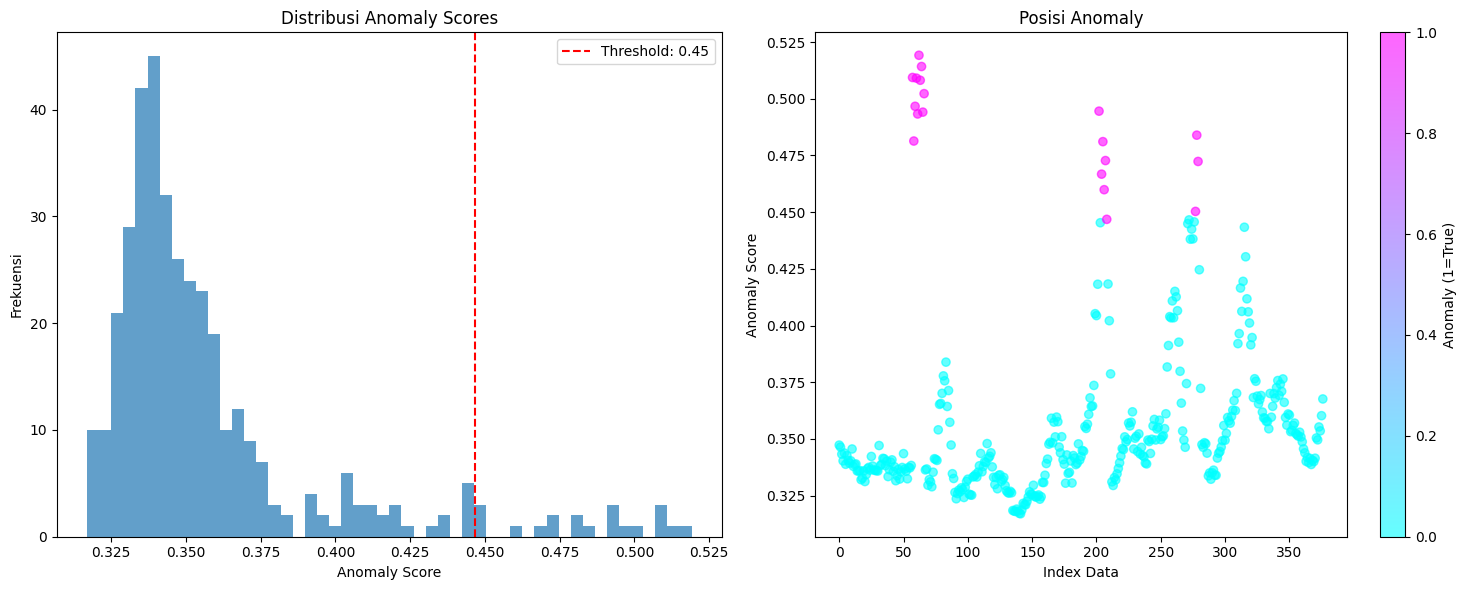


📊 Isolation Forest Results Summary:
Total samples: 377
Detected anomalies: 19 (5.04%)
Contamination parameter: 0.05
Auto-computed threshold: 0.4466


In [26]:
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import numpy as np

def isolation_forest_anomaly_detection(data, use_sequences=True, contamination='auto',
                                       n_estimators=100, max_samples='auto',
                                       random_state=42, plot_results=True):
    if use_sequences:
        X = data['sequences']
        X_reshaped = X.reshape(X.shape[0], -1)
        print(f"🔄 Menggunakan data sequences (3D) - Reshaped: {X_reshaped.shape}")
    else:
        X_reshaped = data['scaled_df'][data['feature_columns']].values
        print(f"🔄 Menggunakan data tabular (2D) - Shape: {X_reshaped.shape}")

    model = IsolationForest(
        n_estimators=n_estimators,
        contamination=contamination,
        max_samples=max_samples,
        random_state=random_state,
        verbose=0
    )

    print("🔨 Training Isolation Forest model...")
    model.fit(X_reshaped)

    anomaly_scores = -model.score_samples(X_reshaped)
    anomalies = model.predict(X_reshaped) == -1

    threshold = np.percentile(anomaly_scores, 100 * (1 - contamination)) if isinstance(contamination, float) else None

    results = {
        'model': model,
        'anomaly_scores': anomaly_scores,
        'anomalies': anomalies,
        'threshold': threshold,
        'contamination': contamination,
        'n_estimators': n_estimators,
        'data_shape': X_reshaped.shape,
        'parameters': {
            'max_samples': max_samples,
            'random_state': random_state
        }
    }

    if plot_results:
        plt.figure(figsize=(15, 6))

        plt.subplot(1, 2, 1)
        plt.hist(anomaly_scores, bins=50, alpha=0.7)
        if threshold:
            plt.axvline(threshold, color='r', linestyle='--', label=f'Threshold: {threshold:.2f}')
        plt.title('Distribusi Anomaly Scores')
        plt.xlabel('Anomaly Score')
        plt.ylabel('Frekuensi')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.scatter(range(len(anomaly_scores)), anomaly_scores, c=anomalies, cmap='cool', alpha=0.6)
        plt.title('Posisi Anomaly')
        plt.xlabel('Index Data')
        plt.ylabel('Anomaly Score')
        plt.colorbar(label='Anomaly (1=True)')

        plt.tight_layout()
        plt.show()

    print("\n📊 Isolation Forest Results Summary:")
    print(f"Total samples: {len(anomaly_scores)}")
    print(f"Detected anomalies: {sum(anomalies)} ({sum(anomalies)/len(anomalies)*100:.2f}%)")
    print(f"Contamination parameter: {contamination}")
    if threshold:
        print(f"Auto-computed threshold: {threshold:.4f}")

    return results

if_results = isolation_forest_anomaly_detection(
    data=results,
    use_sequences=True,
    contamination=0.05,
    n_estimators=200,
    max_samples=0.8,
    random_state=42
)


In [27]:
anomaly_indices = np.where(if_results['anomalies'])[0]

# Tampilkan indeksnya
print("📌 Index data yang termasuk anomaly:")
print(anomaly_indices)

# Tampilkan datanya jika ingin melihat isi sequence-nya
anomalous_data = results['sequences'][anomaly_indices]
print("📌 Data anomaly:")
print(anomalous_data)

📌 Index data yang termasuk anomaly:
[ 57  58  59  60  61  62  63  64  65  66 202 204 205 206 207 208 277 278
 279]
📌 Data anomaly:
[[[9.23076923e-02 4.58715596e-02 9.85221675e-03 ... 3.19932302e-06
   3.16694470e-05 3.50602776e-03]
  [1.38461538e-01 6.42201835e-02 1.47783251e-02 ... 3.19932302e-06
   3.99826768e-05 3.56766260e-03]
  [2.30769231e-01 1.10091743e-01 1.97044335e-02 ... 3.19932302e-06
   4.03785449e-05 3.62901868e-03]
  ...
  [7.69230769e-02 4.58715596e-02 9.85221675e-03 ... 3.19932302e-06
   1.47262928e-04 4.32202484e-03]
  [1.46153846e-01 5.50458716e-02 1.47783251e-02 ... 1.19974613e-06
   1.48054665e-04 4.38395834e-03]
  [1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 1.00000000e+00
   1.00000000e+00 1.00000000e+00]]

 [[1.38461538e-01 6.42201835e-02 1.47783251e-02 ... 3.19932302e-06
   3.99826768e-05 3.56766260e-03]
  [2.30769231e-01 1.10091743e-01 1.97044335e-02 ... 3.19932302e-06
   4.03785449e-05 3.62901868e-03]
  [1.76923077e-01 1.10091743e-01 1.97044335e-02 ... 1